# Quora Duplicate Questions Detection

- This version is a refactored version of [this](https://www.kaggle.com/sankarshan7/quora-duplicate-question?scriptVersionId=51988650) original kernel
- The [orignal](https://www.kaggle.com/sankarshan7/quora-duplicate-question?scriptVersionId=51988650) `pytorch` kernel is refactored to integrate with `PyTorchLightning` 
- Some `PytorchLightning` refactoring style has been taken from this kernel: [Lish-moa baseline approach by Adrew Lukyanenko](https://www.kaggle.com/artgor/lish-moa-baseline-approach/notebook#Data-exploration)

In [1]:
from sklearn import model_selection

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

DIR = '/kaggle/input'

## Data Cleaning and preparation

In [47]:
!ls -lh /kaggle/input/quora-question-pairs/

total 500M
-rw-r--r-- 1 nobody nogroup 5.0M Dec  5 05:59 sample_submission.csv.zip
-rw-r--r-- 1 nobody nogroup 300M Dec  5 06:00 test.csv
-rw-r--r-- 1 nobody nogroup 174M Dec  5 06:00 test.csv.zip
-rw-r--r-- 1 nobody nogroup  22M Dec  5 05:59 train.csv.zip


In [61]:
!unzip /kaggle/input/quora-question-pairs/sample_submission.csv.zip

Archive:  /kaggle/input/quora-question-pairs/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [3]:
!unzip /kaggle/input/quora-question-pairs/train.csv.zip

Archive:  /kaggle/input/quora-question-pairs/train.csv.zip
  inflating: train.csv               


In [46]:
!unzip /kaggle/input/quora-question-pairs/test.csv.zip

Archive:  /kaggle/input/quora-question-pairs/test.csv.zip
  inflating: test.csv                


In [48]:
!ls -lh

total 573M
---------- 1 root root  263 Jan 17 12:21 __notebook_source__.ipynb
drwxr-xr-x 3 root root 4.0K Jan 17 12:27 exp_logs
-rw-r--r-- 1 root root 456M Jun 11  2018 test.csv
-rw-r--r-- 1 root root  61M Mar  7  2017 train.csv
-rw-r--r-- 1 root root  57M Jan 17 12:25 train_folds.csv


In [62]:
df_sub = pd.read_csv("sample_submission.csv")

In [72]:
df_sub.shape

(2345796, 2)

In [1]:
#df_sub[df_sub.test_id.isin([1046690, 1461432, 379205, 817520, 943911, 1270024,  2345796])]

In [49]:
df_test = pd.read_csv("test.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
df_sub.shape, df_test.shape

((2345796, 2), (3563475, 3))

## Fix `nan` issue in Test data

In [78]:
import numpy as np
df_test = df_test.replace(np.nan, 'nan', regex=True)

In [79]:
df_test.question1.isna().sum(), df_test.question2.isna().sum()

(0, 0)

## Create validation dataset

In [58]:
df = pd.read_csv("train.csv")
df['kfold'] = -1

df = df.sample(frac=1.,random_state=2021).reset_index(drop=True)

kf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(kf.split(X=df, y = df.is_duplicate.values)):
    print(len(train_idx), len(val_idx))
    df.loc[val_idx, 'kfold'] = fold

323432 80858
323432 80858
323432 80858
323432 80858
323432 80858


In [74]:
df.shape

(404290, 7)

In [59]:
df[df.question1.isna()]

,id,qid1,qid2,question1,question2,is_duplicate,kfold
51535,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0,0


In [60]:
df[df.question2.isna()]

,id,qid1,qid2,question1,question2,is_duplicate,kfold
246807,201841,303951,174364,How can I create an Android app?,NaN,0,3
355071,105780,174363,174364,How can I develop android app?,NaN,0,4


## Fix `nan` issue in `train` data

In [6]:
df.dropna(inplace=True)

In [7]:
df.question1.isna().sum(), df.question2.isna().sum(), df.question1.isnull().sum(), df.question2.isnull().sum()

(0, 0, 0, 0)

In [8]:
df.to_csv("train_folds.csv", index=False)

In [9]:
df_fold = pd.read_csv("train_folds.csv")

# Load Universal Sentence Encode

In [10]:
import tensorflow_hub as hub

In [11]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [12]:
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

embeddings

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.03133015, -0.06338634, -0.01607501, ..., -0.03242781,
        -0.0457574 ,  0.05370456],
       [ 0.05080863, -0.01652433,  0.01573781, ...,  0.00976658,
         0.03170123,  0.01788119]], dtype=float32)>

In [13]:
import torch

In [14]:
#Reproducing same results
SEED = 2021

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [15]:
import torch.nn as nn

In [16]:
BATCH_SIZE = 256

In [17]:
import pytorch_lightning as pl

In [19]:

FOLD_MAPPPING = {
    0: [1, 2, 3, 4],
    1: [0, 2, 3, 4],
    2: [0, 1, 3, 4],
    3: [0, 1, 2, 4],
    4: [0, 1, 2, 3]
}

In [20]:
FOLD = 0

In [21]:
train_df = df_fold[df_fold.kfold.isin(FOLD_MAPPPING.get(FOLD))].reset_index(drop=True)
valid_df = df_fold[df_fold.kfold==FOLD].reset_index(drop=True)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Network Architecture

- Before integrating with the `pytorchlightning`, let's desing the network in vanilla pytorch

- The original architecture idea came from [here](https://www.linkedin.com/pulse/duplicate-quora-question-abhishek-thakur/). But the original architecture is heavily simplified with the use of transfer learning using `Universal Sentence Encoder`

<center>
<img src='https://raw.githubusercontent.com/msank00/Kaggle_202101_Quora_Duplicate_Questions/main/images/NN_Architecture.jpg' width='400'>    
</center>

In [23]:
class IsDuplicateAdv(nn.Module):
    def __init__(self, output_dim: int, emb_dim: int, hid_dim=512):
        """Non Linear model
        """
        super().__init__()
        #dense layer
        
        self.batchnorm1 = nn.BatchNorm1d(emb_dim * 2)
        self.dropout = nn.Dropout(p=0.2)
        self.nonlinear = nn.PReLU()
        
        self.fc1 = nn.Linear(emb_dim * 2, hid_dim)
        self.batchnorm2 = nn.BatchNorm1d(hid_dim)
        self.fc2 = nn.Linear(hid_dim, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text1:[str], text2:[str]):
        """
        text1: list of strings from question1, len: batch_size
        text2: list of strings from question2, len: batch_size
        """
        
        emb1 = embed(text1)
        e1 = torch.from_numpy(emb1.numpy())
        
        emb2 = embed(text2)
        e2 = torch.from_numpy(emb2.numpy())
        
        # merged
        x = torch.cat((e1, e2), dim = 1)
        x = self.batchnorm1(x)
        
        
        x=self.fc1(x)
        x = self.nonlinear(x)
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        x=self.fc2(x)

        #Final activation function
        outputs=self.act(x)
        
        return outputs

In [24]:
import torch.optim as optim
criterion = nn.BCELoss()

In [25]:
#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.argmax(preds, dim=1)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

## Wrap vanila `pytorch` network with `pytorchlightning`

In [26]:
class QuoraQPair(pl.LightningModule):
    def __init__(self, model: IsDuplicateAdv):
        super().__init__()
        self.model = model
        
    def forward(self, text1:[str], text2:[str]):
        return self.model(text1, text2)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        return optimizer
    
    def training_step(self, batch, batch_idx: int):
        q1, q2, label = batch['q1'], batch['q2'], batch['label'] 
        label = label.float()
        predictions = self.model(q1, q2)
        loss = criterion(predictions[:,1], label) 
        acc = binary_accuracy(predictions, label) 
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return {'loss': loss, 'acc': acc}

    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        self.log('avg_train_loss', avg_loss, on_epoch=True, sync_dist=True, prog_bar=False,logger=True,on_step=False)
        self.log('avg_train_acc', avg_acc, on_epoch=True, sync_dist=True, prog_bar=False,logger=True,on_step=False)
    
    def validation_step(self, batch, batch_idx: int):
        q1, q2, label = batch['q1'], batch['q2'], batch['label'] 
        label = label.float()
        predictions = self.model(q1, q2)
        loss = criterion(predictions[:,1], label) 
        acc = binary_accuracy(predictions, label) 
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('valid_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'acc': acc}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        self.log('avg_val_loss', avg_loss, on_epoch=True, sync_dist=True, prog_bar=False,logger=True,on_step=False)
        self.log('avg_val_acc', avg_acc, on_epoch=True, sync_dist=True, prog_bar=False,logger=True,on_step=False)
        
        

**NOTE**

- Set `on_step=False` for better logging 

# Data Module

- [pl.DataModule Official Document](https://pytorch-lightning.readthedocs.io/en/stable/datamodules.html)
- [How to use it in real case - Kaggle MoA Prediction by Andrew Lukyanenko](https://www.kaggle.com/artgor/lish-moa-baseline-approach)

In [27]:
from torch.utils.data import DataLoader, Dataset

In [28]:
class QuoraTrainData(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        q1 = self.df.iloc[idx].question1
        q2 = self.df.iloc[idx].question2
        label = self.df.iloc[idx].is_duplicate
        
        return {"q1": q1, "q2": q2, "label": label}

In [83]:
class QuoraTestData(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        q1 = self.df.iloc[idx].question1
        q2 = self.df.iloc[idx].question2
        
        return {"q1": q1, "q2": q2}

In [29]:
class QuoraQPairDataModule(pl.LightningDataModule):
    def __init__(self, train_df:pd.DataFrame, valid_df: pd.DataFrame, batch_size:int):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.valid_df = valid_df
        
    def prepare_data(self):
        # any data downloading / preprocessing
        pass
    
    def setup(self, stage=None):
        # setup torch dataset
        self.train_dataset = QuoraTrainData(self.train_df)
        self.valid_dataset = QuoraTrainData(self.valid_df)
    
    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
        return train_loader
    
    def val_dataloader(self):
        valid_loader = DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=4)
        return valid_loader
    
    def test_dataloader(self):
        pass

In [30]:
from pytorch_lightning import Callback
class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = {"train": [], "val": []}

    def on_validation_end(self, trainer, pl_module):
        self.metrics["val"].append(trainer.logged_metrics)
    
    def on_train_end(self, trainer, pl_module):
        self.metrics["train"].append(trainer.logged_metrics)

In [31]:
net = IsDuplicateAdv(output_dim=2, emb_dim=512)
model = QuoraQPair(net)
dm = QuoraQPairDataModule(train_df, valid_df, BATCH_SIZE)

## Set logger for accessing training history

- [PyTorch CSVLOgger](https://pytorch-lightning.readthedocs.io/en/latest/generated/pytorch_lightning.loggers.CSVLogger.html)

In [32]:
from pytorch_lightning.loggers import CSVLogger

In [33]:
# logger
import os
csvlogger = CSVLogger(
    save_dir=os.getcwd(),
    name="exp_logs"
)
os.getcwd()

'/kaggle/working'

In [34]:
metrics_callback = MetricsCallback()

In [35]:
trainer = pl.Trainer(max_epochs=5,
                     default_root_dir=os.getcwd(),
                     logger=csvlogger,
                     deterministic=True) # callbacks = [metrics_callback]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


In [36]:
trainer.fit(model, dm)


  | Name  | Type           | Params
-----------------------------------------
0 | model | IsDuplicateAdv | 528 K 


1

# How to log metrics properly using PyTorchLightning

- [Why are losses different when logging from '_step' (with on_epoch=True) compared to logging from '_epoch_end'? #5539](https://github.com/PyTorchLightning/pytorch-lightning/issues/5539)
- [Understanding different values of training/validation loss in callback_metrics dictionary](https://forums.pytorchlightning.ai/t/understanding-different-values-of-training-validation-loss-in-callback-metrics-dictionary/568)

In [2]:
ls -lh exp_logs/

ls: cannot access 'exp_logs/': No such file or directory


In [38]:
df_metrics = pd.read_csv('exp_logs/version_0/metrics.csv')

In [39]:
df_metrics

,valid_loss,valid_acc,avg_val_loss,avg_val_acc,epoch,step,train_loss,train_acc,avg_train_loss,avg_train_acc
0,0.425694,0.784080,0.426092,0.784777,0,1263,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0,1263,0.506279,0.728756,0.506279,0.728756
2,0.372928,0.817596,0.372762,0.818272,1,2527,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1,2527,0.395335,0.800068,0.395335,0.800068


In [40]:
df_metrics_val = df_metrics[["avg_val_loss", "avg_val_acc", "epoch"]].dropna()
df_metrics_train = df_metrics[["avg_train_loss", "avg_train_acc", "epoch"]].dropna()

In [41]:
df_metrics_val.avg_val_loss.values

array([0.42609182, 0.37276155])

# Training performance

In [42]:
%matplotlib inline
from matplotlib import pyplot as plt

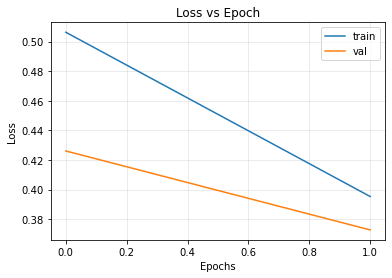

In [43]:
plt.plot(df_metrics_train.avg_train_loss.values, label="train")
plt.plot(df_metrics_val.avg_val_loss.values, label="val")
plt.title("Loss vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

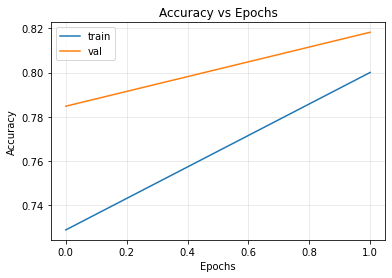

In [44]:
plt.plot(df_metrics_train.avg_train_acc.values, label="train")
plt.plot(df_metrics_val.avg_val_acc.values, label="val")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Prepare test data

In [87]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [90]:
test_dataset = QuoraTestData(df_test)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=4)

# Inference

In [110]:
predictions = np.zeros(df_test.shape[0])
model_inference = model.model
model_inference.eval()

IsDuplicateAdv(
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (nonlinear): PReLU(num_parameters=1)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (act): Sigmoid()
)

In [111]:
test_iter = iter(test_loader)
tres = test_iter.next()

In [115]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [112]:
temp = model_inference(tres['q1'], tres['q2'])[:,1].detach().cpu().numpy()
temp

array([0.02157024, 0.08295897, 0.17215538, ..., 0.07896128, 0.27500734,
       0.00847912], dtype=float32)

In [113]:
predictions

array([0., 0., 0., ..., 0., 0., 0.])

In [96]:
from tqdm import tqdm

In [114]:
for ind, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
    p = model_inference(batch['q1'], batch['q2'])[:,1].detach().cpu().numpy()
    predictions[ind * 1024:(ind + 1) * 1024] = p

100%|██████████| 3480/3480 [19:54<00:00,  2.91it/s]


In [117]:
predictions.shape

(3563475,)

In [118]:
s = pd.DataFrame({'test_id': df_test['test_id'].values, 'is_duplicate': predictions})

In [119]:
s.head()

,test_id,is_duplicate
0,0,0.021570
1,1,0.082959
2,2,0.172155
3,3,0.015365
4,4,0.176046


In [121]:
s.to_csv("submission.csv", index=False)

In [9]:
#s.shape
#s[s.test_id.isin([1128118])]
#df_sub.shape
#df_sub.head()
#df_sub[df_sub.test_id.isin([1128118,1128119 ])]